In [3]:
import numpy as np
import matplotlib.pyplot as plt

cmaq3D_array = np.load('CMAQ/2010cmaq3D_array.npy')
PM_array = np.load('PM2.5/2010PM_array.npy')

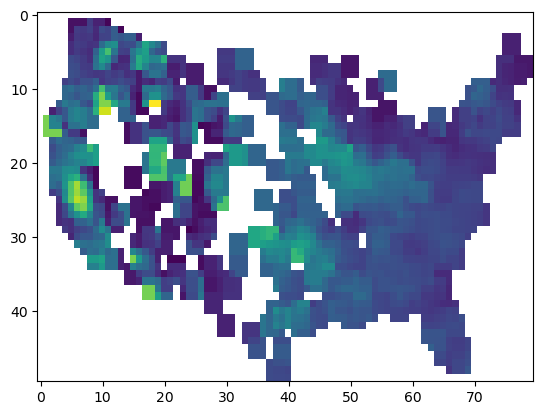

In [4]:
# do kernel convolution for 3x3 mean grids around each point, ignoring na values
# the function was written by ChatGPT if that isn't obvious
from scipy.signal import convolve2d

def nan_aware_uniform_filter(data, size):
    data = np.asarray(data, dtype=float)

    kernel = np.ones((size, size), dtype=float)
    
    # Create a mask of valid values (1 where not nan, 0 where nan)
    valid_mask = (~np.isnan(data)).astype(float)
    
    # Replace NaNs with 0
    data_filled = np.nan_to_num(data, nan=0.0)

    # Convolve data and valid mask with kernel
    convolved_data = convolve2d(data_filled, kernel, mode='same', boundary='symm')
    convolved_mask = convolve2d(valid_mask, kernel, mode='same', boundary='symm')

    # Avoid divide by zero
    with np.errstate(invalid='ignore', divide='ignore'):
        result = convolved_data / convolved_mask
        result[convolved_mask == 0] = np.nan

    return result

plt.imshow(nan_aware_uniform_filter(PM_array[1], size=3), cmap='viridis', aspect='auto')

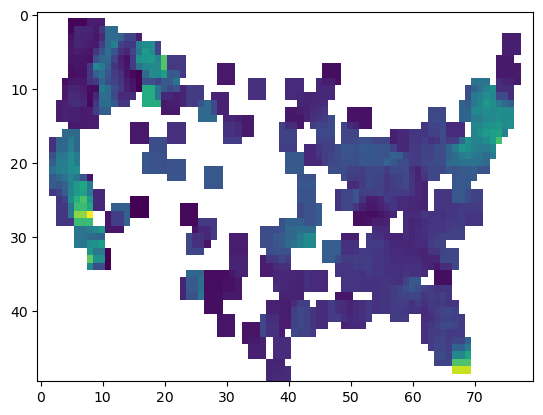

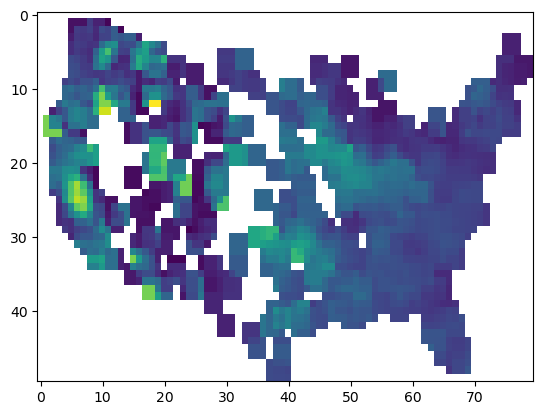

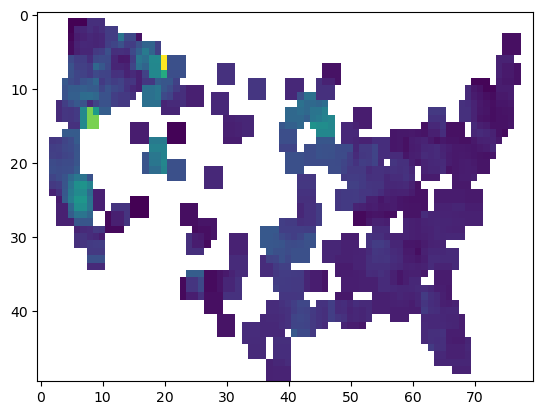

In [16]:
days, _, _ = PM_array.shape
PM3D_array = np.empty_like(PM_array, dtype=float)

for d in range(days):
    PM3D_array[d] = nan_aware_uniform_filter(PM_array[d], size=3)

for d in range(0,3):
    plt.imshow(nan_aware_uniform_filter(PM_array[d], size=3), cmap='viridis', aspect='auto')
    plt.show()

/tmp/ipykernel_78365/80033248.py:4: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(PM3D_array,axis=0), cmap='viridis', aspect='auto')


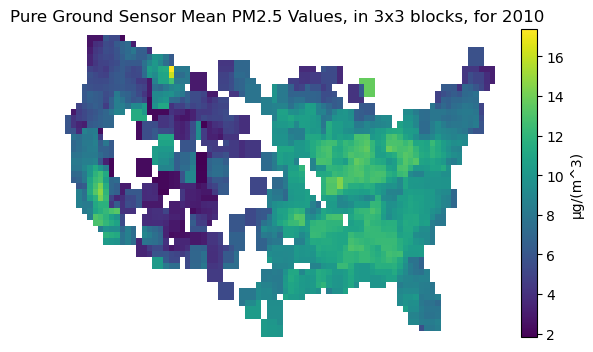

In [6]:
# mean of each square for all of 2010, ignoring nans 
plt.figure(figsize=(7,4))
plt.title("Pure Ground Sensor Mean PM2.5 Values, in 3x3 blocks, for 2010")
plt.imshow(np.nanmean(PM3D_array,axis=0), cmap='viridis', aspect='auto')
plt.colorbar(label = 'µg/(m^3)')
plt.axis('off')
plt.savefig('groundsensor3x3meanpm2.5values2010.png', dpi=300, bbox_inches = 'tight')

# Model for just 2010

In [7]:
# train-test split, first 9 months vs last 3 months
# remove december, november, october
daySplit = 365 - 31 - 30 - 31
daySplit
train_x = PM3D_array[0:daySplit]
test_x = PM3D_array[daySplit:]
display(train_x.shape)
display(test_x.shape)

(273, 50, 80)

(92, 50, 80)

In [8]:
train_y = cmaq3D_array[0:daySplit]
test_y = cmaq3D_array[daySplit:]
display(train_y.shape)
display(test_y.shape)

(273, 50, 80)

(92, 50, 80)

Simplest possible model: Y = aX + b, where a and b are scalars

In [9]:
from scipy.linalg import norm
import numpy as np

# Y = A X
# params is one scalar multiple
def objective(params, X, Y):
    scalar = params[0]
    
    # objective is the L2 norm of Y - Y_hat, or Y - A X
    return norm(Y - (scalar * np.nan_to_num(X)))

In [10]:
# probably larger bounds than necessary but it works
bounds = [(-100, 100),]

In [11]:
from scipy.optimize import differential_evolution

# find the best params
result = differential_evolution(objective, bounds, args = (train_x,train_y))
display(result)

             message: Optimization terminated successfully.
             success: True
                 fun: 4369.069486140855
                   x: [ 6.014e-01]
                 nit: 10
                nfev: 173
          population: [[ 6.021e-01]
                       [ 6.580e-01]
                       ...
                       [ 5.010e-01]
                       [ 6.244e-01]]
 population_energies: [ 4.369e+03  4.387e+03 ...  4.425e+03  4.372e+03]
                 jac: [ 0.000e+00]

In [12]:
train_y_hat = result['x'][0] * train_x
test_y_hat = result['x'][0] * test_x

In [13]:
# train RMSE
np.nanmean((train_y - train_y_hat)**2)**0.5

3.792554519960929

In [14]:
# test RMSE
np.nanmean((test_y - test_y_hat)**2)**0.5

4.536013106027305

/tmp/ipykernel_78365/356205631.py:3: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean((test_y - test_y_hat)**2, axis=0)**0.5, cmap='viridis', aspect='auto')


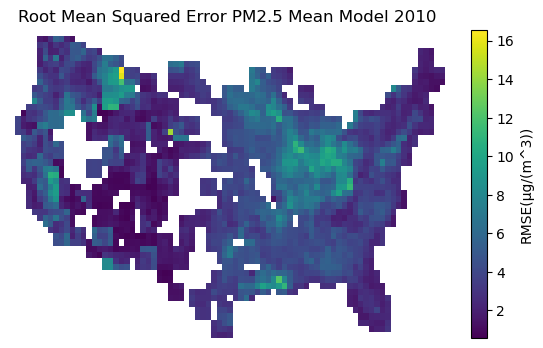

In [15]:
plt.figure(figsize=(7,4))
plt.title("Root Mean Squared Error PM2.5 Mean Model 2010")
plt.imshow(np.nanmean((test_y - test_y_hat)**2, axis=0)**0.5, cmap='viridis', aspect='auto')
plt.colorbar(label = 'RMSE(µg/(m^3))')
plt.axis('off')
plt.savefig('RMSEmeanmodelpm2.52010.png', dpi=300, bbox_inches = 'tight')
plt.show()